In [3]:
# import librerie
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
from timeit import timeit, default_timer

# ESERCIZIO 1:
Modificare l'esempio del "Gear Shift Control" in modo che la marcia sia una funzione della velocità. 

Risolvere il nuovo problema numericamente. Notare che ora gli istanti di switch non sono noti a priori quindi l'integrazione con stop e reinizializzazione richiederebbe il calcolo di tali istanti.

Tempo =  0.03290170000400394


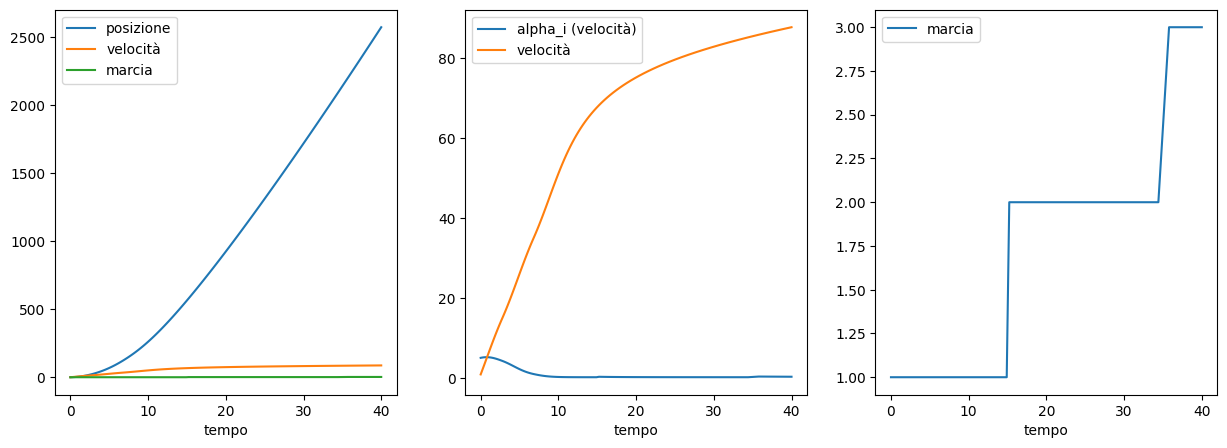

In [9]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (10 * np.power(sig, 2.)))

mu1=5; mu2=mu1+20; mu3=mu2+20; mu4=mu3+20;
sig0=7;
def alpha(gear,x2):
    k=5; q=0.3;
    if gear==1:
        return q+k*gaussian(x2, mu1, sig0)
    elif gear==2:
        return q+k*gaussian(x2, mu2, sig0)
    elif gear==3:
        return q+k*gaussian(x2, mu3, sig0)
    elif gear==4:
        return q+k*gaussian(x2, mu4, sig0)


def gear(v):
    m = 0
    for i in range(4):
        if alpha(i+1,v) > m:
            m = alpha(i+1,v)
        else:
            return i
    return i   
#end

def u(t): return 1

def func(t,y):
    dx1 = y[1]  # vel
    dx2 = alpha(gear(y[1]),y[1])*u(t)
    return np.array([dx1,dx2])
#end


tf = 40

time1 = default_timer()
sol = solve_ivp(func, [0, tf], [1.,1.], rtol=1e-10,atol=1e-10 )
time2 = default_timer()
print('Tempo = ', time2-time1)

#GRAFICO
plt.figure(figsize=(15,5));
plt.subplot(1,3,1);
plt.plot(sol.t, sol.y[0,:], '-', label='posizione');
plt.plot(sol.t, sol.y[1,:], '-', label='velocità');
plt.plot(sol.t, [gear(k) for k in sol.t],'-',label='marcia');
plt.xlabel('tempo');
plt.legend();

plt.subplot(1,3,2);
plt.plot(sol.t, [alpha(gear(k),dotx) for (k,dotx) in zip(sol.t,sol.y[1,:])], '-', label='alpha_i (velocità)')
plt.plot(sol.t, sol.y[1,:], '-',label='velocità'); 
plt.xlabel('tempo');
plt.legend();

plt.subplot(1,3,3); 
plt.plot(sol.t, [gear(k) for k in  sol.t], '-', label='marcia') ; plt.xlabel('tempo'); plt.legend();

# ESERCIZIO 2: Water Tank System  (Avanzato, solo lettura)

Esempio classico, tratto dallo stesso del notebook precedente: https://fenix.tecnico.ulisboa.pt/downloadFile/3779579688470/lygeros.pdf

In questo esercizio consideriamo un sistema di due serbatoi contenenti dell'acqua.

Entrambi hanno delle perdite costanti dovute ad una apertura sul fondo, ma vengono riempiti d'acqua tramite un tubo che in ogni istante di tempo riempie solamente uno di questi. Si suppone che il passaggio da un contenitore all'altro sia istantaneo.

Denotiamo con $i=0,1$ i due serbatoi, 
- $y_i$ è il volume di acqua nel serbatoio $i$,
- $v_i$ il flusso costante di acqua che esce dal serbatoio $i$,
- $w$ il flusso costante in ingresso ai contenitori.

Lo scopo è mantenere i volumi di acqua sopra ai livelli $r_0$ e $r_1$ rispettivamente, assumendo che inizialmente siano entrambi sopra a tali valori.

Se il tubo riempie il primo serbatoio allora le equazioni sono:
$$
\begin{cases}
y'_0(t) = w - v_0\\
y'_1(t) = -v_1
\end{cases}
$$
Altrimenti, se il tubo riempie il secondo serbatoio allora le equazioni sono:
$$\begin{cases}
y'_0(t) = - v_0\\
y'_1(t) = w-v_1
\end{cases}
$$
Il controllo dovrà muovere il tubo dal serbatoio 0 al 1, e viceversa, a seconda della necessità: dovrà rimanere nel serbatoio in cui è, fino a che il livello dell'altro serbatoio non è minore del livello di riferimento, e solo in tal caso cambiare.

Per far questo creiamo una variabile fittizia, $ y_2(t) \in \{0,1\}$, che indica ad ogni istante il serbatoio che viene riempito.

Dunque ad ogni istante di tempo $t$ si deve avere:
- $y_2 = 0 \;$  se  ($y_2=0$ e $y_1>=r_1$) o se ($y_2=1$ e $y_0<r_0$)
- $y_2 = 1\;$   se  ($y_2=1$ e $y_0>=r_0$) o se ($y_2=0$ e $y_1<r_1$)

In [5]:
# import librerie
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Cambio di refill negli istanti: [0.24999444 1.77368634 3.29608789 4.80195056 6.32620733 7.82812075
 9.34299152]


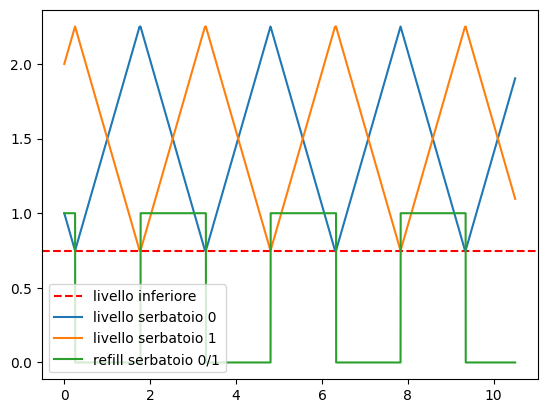

In [6]:
v0 = 1.; v1 = 1.0; w =2.;
r0 = 0.75;  r1=r0;

def func0(t, y): return np.array([w - v0 ,    -v1,  0])
def func1(t, y): return np.array([  - v0 ,  w -v1,  0])

def func(t,y):
    if (y[2]<0.5 and y[1]>=r1) or (y[2]>0.5 and y[0]<r0) :
        y[2]=0;
        return func0(t,y)
    elif (y[2]>0.5 and y[0]>=r0) or (y[2]<0.5 and y[1]<r1):
        y[2]=1;
        return func1(t,y)
    else :
        print('error :',t,y[1],y[2])
        return func1(t,y)
    #end
    
# EVENTO:
def limite_inferiore(t, y): return (y[0]-r1)*(y[1]-r1)

limite_inferiore.terminal  = False
limite_inferiore.direction = -1

tf  = 10.5;
sol = solve_ivp(func, [0, tf], [1.0,2.0,2.0], rtol=1e-4,atol=1e-6,t_eval=np.arange(0.0,tf,0.001),events=limite_inferiore)

# GRAFICO
plt.axhline(y=r1,color='r',linestyle='--', label='livello inferiore');
plt.plot(sol.t, sol.y[0,:],'-',label='livello serbatoio 0')
plt.plot(sol.t, sol.y[1,:],'-',label='livello serbatoio 1')
plt.plot(sol.t, sol.y[2,:],'-',label='refill serbatoio 0/1')
plt.legend();
print('Cambio di refill negli istanti:', sol.t_events[0])

### OSSERVAZIONI: 

1) Questo sistema è un sistema **ibrido** in cui le variabili continue sono il livello d'acqua nei serbatoi $y_0,y_1$ , mentre la variabile discreta è quella che ad ogni istante indica il serbatoio che viene riempito.
La libreria scipy.integrate non fornisce un metodo apposito per questo tipo di problemi, ma è stato possibile comunque risolvere il problema creando una variabile fittizia nel sistema da integrare, alla quale viene assegnata derivata nulla e che viene modificata all'interno della funzione delle derivate.


2) I parametri considerati costituiscono un caso *particolare* limite di questo problema. Se il flusso in ingresso non fosse sufficientemente elevato infatti, non sarebbe sufficiente a mantenere i livelli di acqua sopra alla soglia richiesta e questi si svuoterebbero. Viceversa se la quantità d'acqua in ingresso fosse maggiore potrebbero riempirsi troppo. Per complicare ulteriormente il problema sarebbe necessario ad esempio considerare il flusso in ingresso non costante ma *variabile* nel tempo.

# ESERCIZIO 3: Blocco che oscilla (Avanzato, solo lettura)
#### Tratto da:  Di Bernardo, Budd, Champneys, Kowalczyk, 'Piecewise-smooth Dynamical' Systems pag 312, esempio 7.2, "The rocking block"
Un problema legato allo studio del comportamento degli edifici durante i terremoti è quello del movimento di un blocco su un tavolo che oscilla. 
La situazione che consideriamo è quella mostrata in figura (immagine tratta dal libro): il blocco oscilla sui due angoli $P$ e $Q$ a seconda che l'angolo $\theta$ formato con la verticale sia negativo o positivo.
<img src="https://i.postimg.cc/PJchwBcM/Rocking-block.jpg" alt="drawing" width="500"/>

Se modelliamo la transizione tra le oscillazioni sui due angoli del blocco come istantanee, otteniamo un sistema continuo a tratti. Chiamando $\theta$ l'angolo che il blocco forma con la verticale, la superficie di discontinuità è data da $\theta=0$ e il sistema si può scrivere come:


\begin{cases}
I \ddot{\theta}  + m\, g\, R\, sin(-\alpha -\theta) &= -m \, \ddot{u_g} \, R\, cos(-\alpha -\theta)   \quad & \text{se } \theta<0\\
I \ddot{\theta}  + m\, g\, R\, sin(\alpha -\theta) &= -m \, \ddot{u_g} \, R\, cos(\alpha -\theta)   \quad &\text{se } \theta>0
\end{cases}

dove
- $\theta$ è l'angolo del blocco rispetto alla verticale
- $u_g$ è l'accelerazione orizzontale del terreno (ground)
- $\alpha$ è l'angolo fissato tra il blocco e il centro di massa
- $R$ la lunghezza della linea tra l'angolo e il centro di massa
- $m$ la massa
- $I$ il momento d'inerzia


Supponendo che $\alpha$ e $\theta$ siano relativamente piccoli, usiamo delle approssimazioni lineari per le funzioni trigonometriche. 
Quindi, riscalando il risultato e considerando una accelerazione sinusoidale del terreno $u_g = sin(\omega t + \phi)$
otteniamo il sistema linearizzato:

\begin{cases}
\ddot{\theta} - \theta = \beta sin(\omega t + \phi) + \alpha    & \quad \text{se }  \theta<0\\
\ddot{\theta} - \theta = \beta sin(\omega t + \phi) - \alpha    & \quad\text{se }   \theta>0\
\end{cases}


Risolviamo il problema, ad esempio con condizioni iniziali 
$$\theta(0)=0, \; \dot{\theta}(0) = 0.1$$
e con i parametri indicati nella cella seguente.

In [7]:
beta = 0.005
omega = 1.
phi = 0;
alpha = 0.2;

y0 = np.array([0,0.1]);

def func(t,y) :
    if y[1]<0:
        return np.array([y[1] + beta*np.sin(omega*t+phi)+alpha, y[0]])
    else:
        return np.array([y[1] + beta*np.sin(omega*t+phi)-alpha, y[0]])
    #end if
#end def

tf = 20.
sol = solve_ivp(func, [0, tf], y0, rtol=1e-8,atol=1e-8,t_eval=np.arange(0.0,tf,0.001))


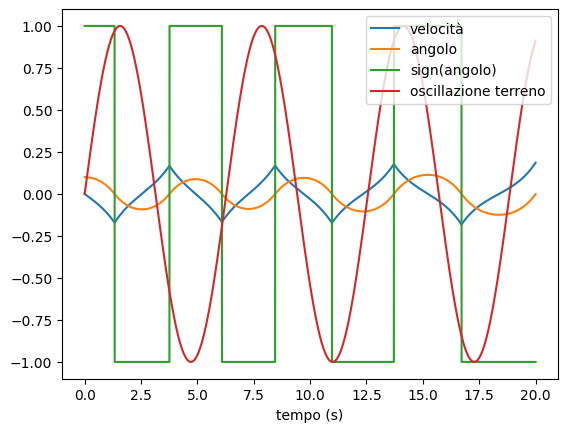

In [8]:
plt.plot(sol.t, sol.y[0,:],'-',label='velocità');
plt.plot(sol.t, sol.y[1,:],'-',label='angolo');
plt.plot(sol.t, np.sign(sol.y[1,:]),'-',label='sign(angolo)');
plt.plot(sol.t, np.sin(omega*sol.t + phi ), label ='oscillazione terreno');
plt.xlabel('tempo (s)')
plt.legend();

### Suggerimento: provare l'animazione del risultato.